
# From baseline measurements and the time till the last visit we here try to predict disease progression in the future

Disease progression is defined as worsening of diagnosis on the last visit compared to the the baseline diagnosis.

# 1 Data loading, preperation and cleaning

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.base import clone

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [2]:
adni_df = pd.read_csv("../data/ADNIMERGE.csv")
# print(adni_df.shape)
adni_df.head(4)

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,CN,-4.35795,-4.15975,2005-09-08,0.0,10.67,18.67,5.0,28,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.35795,-4.15975,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,Dementia,-16.58450,-16.16580,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,31863.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,Dementia,-15.02030,-13.38660,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2018-11-08 22:51:22.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.09690,NaN,NaN,601.4,251.7,24.18,3.5,24.00,35.00,10.0,17.0,31.0,2.0,7.0,100.0000,0.0,21.0,126.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,35576.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,Dementia,-21.41690,-20.22380,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,179

In [3]:
adni1_df = adni_df[adni_df['ORIGPROT'] == 'ADNI1'].copy()
df = adni1_df.copy()
#print(df['DX_bl'].unique())
#print(df['DX'].unique())

In [4]:
#print('Before dropping: ' , df.shape)
df['DX'] = df['DX'].replace(to_replace='NONE', value=np.nan)
df=df.dropna(axis=0, subset=['DX'])
#print('After dropping: ' , df.shape)
#print(df['DX'].unique())

In [5]:
# All the different visits for our first patient ID
#df[df.PTID=='011_S_0002' ]['M']

In [6]:
# The different unique patient ID
# len(df.PTID.unique())

In [7]:
# The different unique patient ID
# df.M.unique()

In [8]:
indexes_last_visit=[]
for patient_ids in df.PTID.unique():
  latest_visit_M=df[df.PTID==patient_ids]['M'].max()
  d=df[ df.PTID==patient_ids ]['M']== latest_visit_M
  ind=d.index[-1]
  indexes_last_visit.append(ind);
  
# Only last visits
df_last=df.loc[indexes_last_visit]

In [9]:
diction_last_DX={}
for D in df_last['DX'].unique():
  diction_last_DX[D]=df_last[df_last['DX']==D]['M']/12
  
diction_first_DX={}
for D in df_last['DX_bl'].unique():
  diction_first_DX[D]=df_last[df_last['DX_bl']==D]['M']/12

We look when the last visit occors for different groups:
- Based on Diagnosis groups of the first visit (left graph)
 - People with AD at baseline only stayed 2.5 year at the most in our data set.
 - For Normal and MCI patients there were less obvious differences.
- Based on Diagnosis groups of the last visit (right graph)
 - All groups of diagnosis at the last visit have their last visits at similar times. No obvious difference between Dementia/Alzheimer and MCI or Normal diagnosed patients at the last visit.

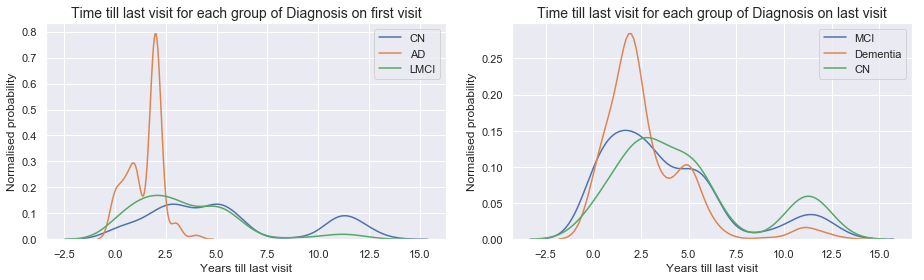

In [10]:
fig, axs= plt.subplots(1,2, figsize=(13,4))
ax=axs.ravel()
for key, val in diction_first_DX.items():
  sns.kdeplot(val, label=key, ax= ax[0])
  ax[0].set_title('Time till last visit for each group of Diagnosis on first visit')
  ax[0].set_xlabel('Years till last visit')
  ax[0].set_ylabel('Normalised probability')
  ax[0].legend()
for key, val in diction_last_DX.items():
  sns.kdeplot(val, label=key, ax= ax[1])
  ax[1].set_title('Time till last visit for each group of Diagnosis on last visit')
  ax[1].set_xlabel('Years till last visit')
  ax[1].set_ylabel('Normalised probability')
  ax[1].legend()
plt.tight_layout()

## 1.2 Data cleaning: we keep only baseline measurments plus the time and the diagnosis of the last visit.
- Dropping meaningless and duplicate features 
- Keep all features of baseline visit
- Drop all features of the last visit measurements except time till last visit and diagnosis

In [11]:
df=df_last
df.head()

# dealing with the '<' and '>' in abeta and tau and ptau
genes = ['TAU_bl', 'ABETA_bl', 'PTAU_bl']
for val in genes:
    all_vals = df[val].values
    df = df.drop(val, axis=1)
    df[val] = [float(str(x).replace('<','').replace('>','')) for x in all_vals]

# drop collinear, unrelated or missing variables
collinear = ['VISCODE', 'update_stamp', 'Month', 'Month_bl', 'Years_bl']
unrelated = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION','FSVERSION_bl', 'IMAGEUID', 'FLDSTRENG','FLDSTRENG_bl', 'EXAMDATE' ,  'EXAMDATE_bl']
baselines = []
nulls = dict(df.isna().sum().sort_values())
null_cols = []
drop_non_bl=['FDG', 'PIB', 'AV45', 'ABETA',
             'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
             'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
             'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR',
             'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat',
             'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal',
             'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
             'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG',
             'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain',
             'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'mPACCdigit',
             'mPACCtrailsB']

empty=['MOCA_bl', 'EcogSPTotal_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl','EcogPtOrgan_bl','EcogPtDivatt_bl',
       'EcogPtTotal_bl','EcogSPMem_bl','EcogSPLang_bl','EcogSPVisspat_bl',
       'EcogSPPlan_bl','EcogSPOrgan_bl','EcogSPDivatt_bl', 'AV45_bl', 'EcogPtMem_bl', 'EcogPtLang_bl'] 

# filling out null_cols and baselines
for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baselines.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baselines.append(i)
        
df = df.drop(collinear + unrelated + null_cols + drop_non_bl + empty, axis=1)

# dealing with categorical variables
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categoricals = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummies = pd.get_dummies(df[categoricals])
df = pd.concat([df, dummies], axis=1)

# more informative names
df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})

# drop categoricals
df = df.drop(categoricals, axis=1)

# making the 'DX' variable numeric
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'Dementia': 3})
df['DX_bl'] = df['DX_bl'].map({'CN': 1, 'LMCI': 2, 'AD': 3})

# dropping rows that are missing the response variable
df = df.dropna(subset=['DX'])
df = df.dropna(subset=['DX_bl'])



## 1.3 Imputation: Missing value imputation by 5 KNN

In [12]:
# imputation through kNN with 5 neighbors

null_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_nulls = null_df[null_df['Nulls'] > 0].to_dict()['Nulls']
nulls = new_nulls.keys()
not_nulls = df.columns.difference(nulls).values
ind_dict = {}

# filling it with a weird value for now
weird_value = -247
df = df.fillna(weird_value)

for n, col in enumerate(nulls):
  # Training set: all the rows for which the entry in the corresponding column does not contain a '0'
  pseudo_train = df[df[col] != weird_value]
  pseudo_x = pseudo_train[pseudo_train.columns.difference([col, 'DX'])]
  pseudo_y = pseudo_train[col]

  # Doing the same for the "test" set
  pseudo_test = df[df[col] == weird_value]
  pseudo_x_tes = pseudo_test[pseudo_test.columns.difference([col, 'DX'])]
  pseudo_y_tes = pseudo_test[col]

  # Fitting a kNN model with N=5
  chosen_model = KNeighborsRegressor(n_neighbors=5).fit(pseudo_x, pseudo_y)

  # Saving the indices into a dictionary
  ind = df[df[col] == weird_value][col].index.values
  ind_dict[col] = chosen_model.predict(pseudo_x_tes)
    
# doing the actual imputation
for col in nulls:
  ind = df[df[col] == weird_value][col].index.values
  df.loc[ind, col] = ind_dict[col]

# 2 Base Logistic Regression Model

We are splitting in a training set (80%) and test set (20%).

In [13]:
# Train-test split for two different models: 
# Splitting in two different cases:
df_1 = df[df['DX_bl']==1]  # Patients with normal diagnosis at baseline
df_2 = df[df['DX_bl']==2]  # Patients with MCI diagnosis at baseline

y_1 = ( df_1['DX'] > df_1['DX_bl'] ) # if Dx went from 1 (Dx_bl )to 2/3 (Dx) -> y =1  if DX did change y=0
X_1 = df_1[df_1.columns.difference(['DX'])]

y_2 = ( df_2['DX'] > df_2['DX_bl'] ) # if Dx went from 2 (Dx_bl )to 3 (Dx) -> y =1  otherwhise y=0
X_2 = df_2[df_2.columns.difference(['DX'])]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.2, random_state=209)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=209)

# print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
# print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

## 2.1 Basic Naive Logistic model only taking into account time till last visit

- Left graph: Disease progression from Normal Baseline to MCI/AD progression on last visit:
 - More progression from normal to MCI or AD after a long time (late last visit); might just be explained by time.
- Right graph: Disease progression from MCI baseline to AD at the last visit.
 - For MCI to AD no real difference in distribution of people with disease progression and stabile disease. 

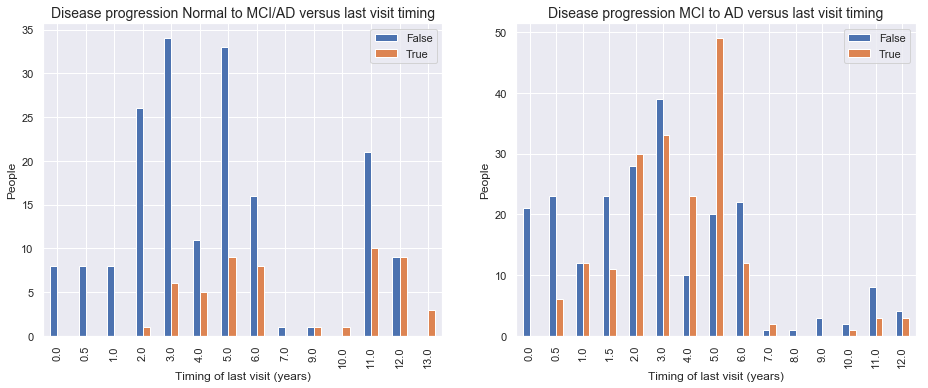

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5.5))
ax1, ax2 = ax.ravel()

pd.crosstab(X_1['M']/12,y_1).plot(kind='bar', ax=ax1)
ax1.set_title('Disease progression Normal to MCI/AD versus last visit timing')
ax1.set_xlabel('Timing of last visit (years)')
ax1.set_ylabel('People')
ax1.legend()

pd.crosstab(X_2['M']/12,y_2).plot(kind='bar', ax=ax2)
ax2.set_title('Disease progression MCI to AD versus last visit timing')
ax2.set_xlabel('Timing of last visit (years)')
ax2.set_ylabel('People')
ax2.legend()

fig.tight_layout()

In [15]:
# Code credit: sklearn example
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm_original=cm.copy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0, fontsize=13)
    ax.set_yticklabels(classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    thresh = 1 / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j]*100, '.0f') +  '%  (' +format(cm_original[i, j], 'd') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    ax.set_title(title, fontsize=15)
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.grid('off')

### 2.1.1 Logistic Regression Disease progression model for baseline normal patients based only on time till last visit

- **The following confusion matrix**: Modeling the disease progression from Normal Baseline progressing to MCI/AD only based on time till last visit.


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.80 , Test accuracy: 	0.63



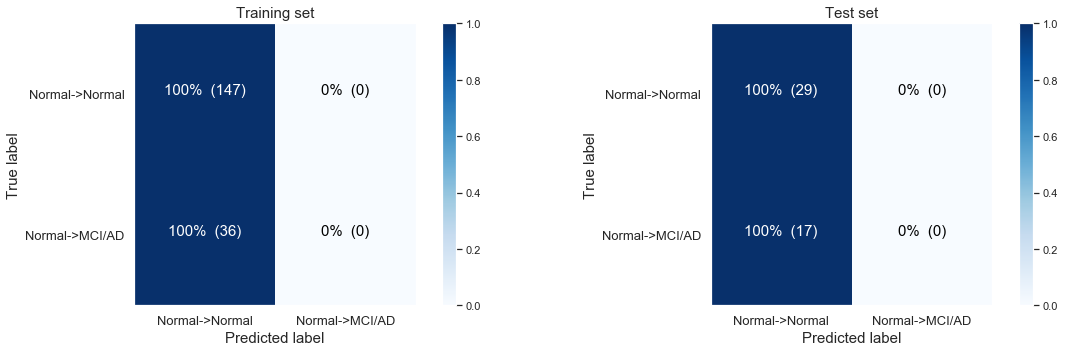

In [16]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

It is more likely for people to stay stabile: 147 stabile versus 36 with disease progression in our training set. If we don't balance for the very unequal classes we end up with a very basic model always "predicting" a person will stay stabile. This is very possible since here we only use the time till the last visit as a variable.

- **The following confusion matrix**: We get a better model when we balance the unequal size groups (by the option ```class_weight='balanced'```) Here we see we are now predicting the people that are showing disease progression, yet of the cost of more False Positives and with very low discrimitive power.


Simple logistic regression modeling with the CLASS WEIGHTS  BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.70 , Test accuracy: 	0.70



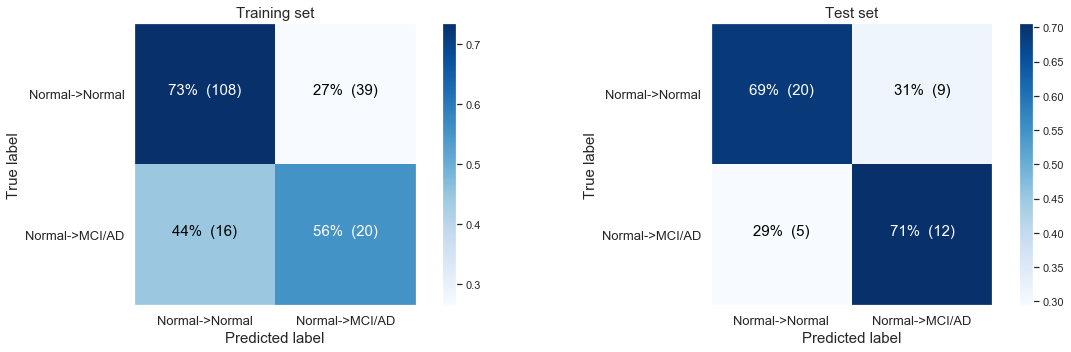

In [17]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS  BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

### 2.1.2  Logistic Regression Disease progression model for baseline MCI patients based only on time till last visit

- **The following confusion matrix**: Modelling non-balanced, MCI Baseline, progressing to AD only based on time till last visit


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit
Training accuracy: 	0.58 , Test accuracy: 	0.49



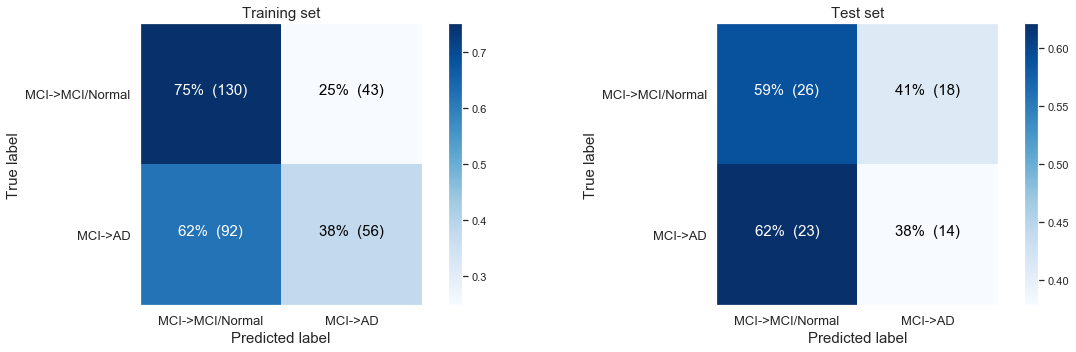

In [18]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

**The following confusion matrix**: Modelling balanced, MCI Baseline, progressing to AD only based on time till last visit, yet now again with balanced class.


Simple logistic regression modeling with the CLASS WEIGHTS BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit
Training accuracy: 	0.61 , Test accuracy: 	0.54



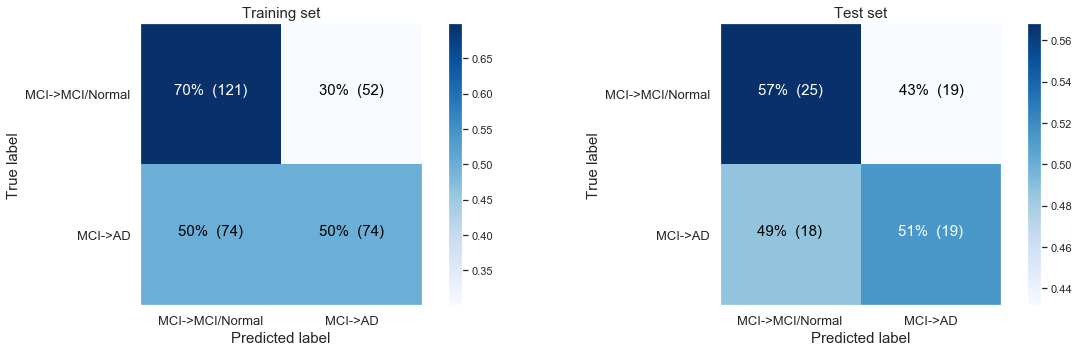

In [19]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

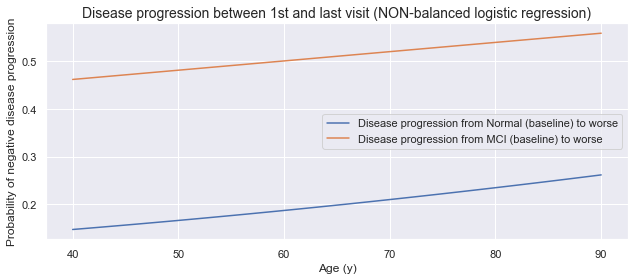

In [20]:
# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)

age= np.linspace(start=40, stop=90, num=50)
pred1= baseline_logreg_1.predict_proba(age.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(age.reshape(-1,1))[:,1]

plt.figure(figsize=(9,4))
plt.plot(age, pred1, label='Disease progression from Normal (baseline) to worse')
plt.plot(age, pred2, label='Disease progression from MCI (baseline) to worse')
plt.legend()
plt.title('Disease progression between 1st and last visit (NON-balanced logistic regression)')
plt.xlabel('Age (y)')
plt.ylabel('Probability of negative disease progression');
plt.tight_layout()

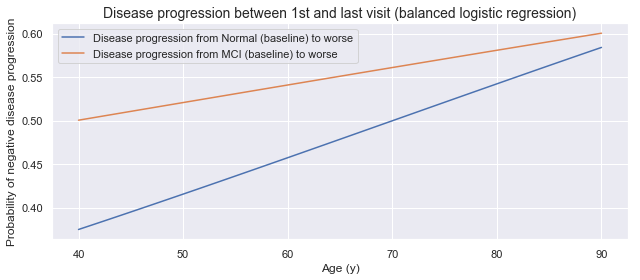

In [21]:
# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)

age= np.linspace(start=40, stop=90, num=50)
pred1= baseline_logreg_1.predict_proba(age.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(age.reshape(-1,1))[:,1]

plt.figure(figsize=(9,4))
plt.plot(age, pred1, label='Disease progression from Normal (baseline) to worse')
plt.plot(age, pred2, label='Disease progression from MCI (baseline) to worse')
plt.legend()
plt.title('Disease progression between 1st and last visit (balanced logistic regression)')
plt.xlabel('Age (y)')
plt.ylabel('Probability of negative disease progression');
plt.tight_layout()

## 2.2 Logistic model  taking into account all baseline measurements and time till last visit

### 2.2.1 Modelling Normal Baseline patients progressing to MCI/AD taking into account all baseline measurements and time till last visit 
- Balanced for the unequal classes


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.75 , Test accuracy: 	0.63



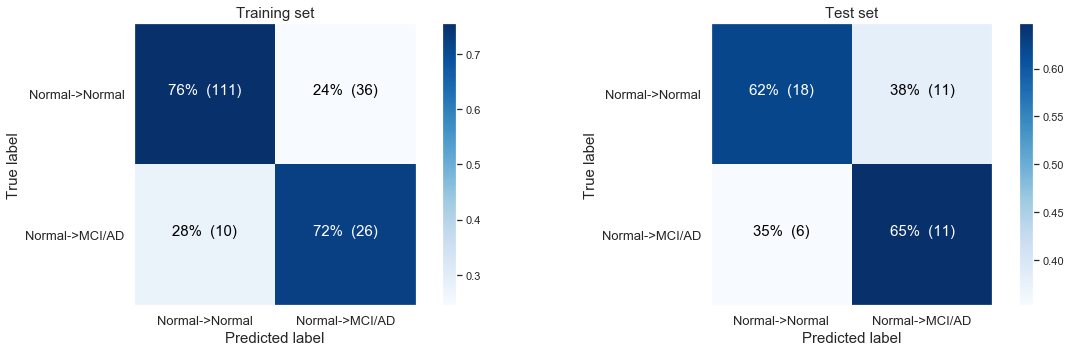

In [22]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1.values, y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_1.score(X_train1.values, y_train1), baseline_logreg_1.score(X_test1.values, y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1.values))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

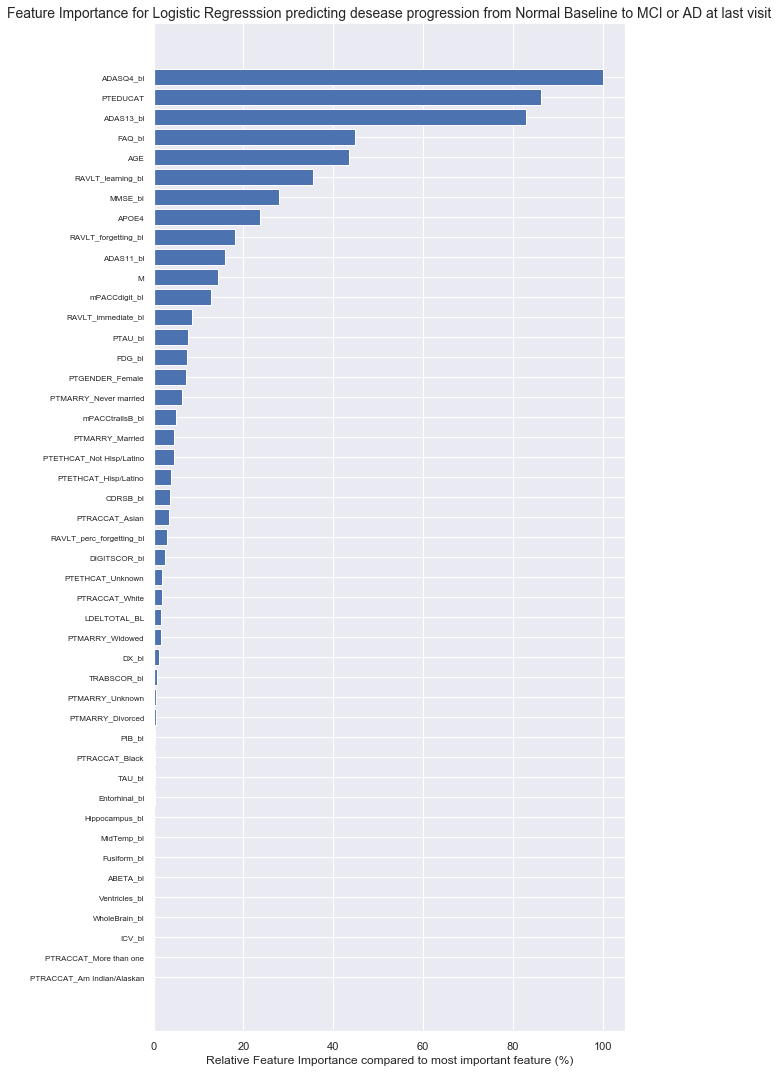

In [23]:
# Feature importance analysis, sort and visualization (for normal baseline model)
feature_importance = abs(baseline_logreg_1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train1.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')

plt.tight_layout()   
plt.show()

### 2.2.1 Modelling MCI Baseline patients progressing to AD taking into account all baseline measurements and time till last visit
- Balanced for the unequal classes


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.76 , Test accuracy: 	0.63



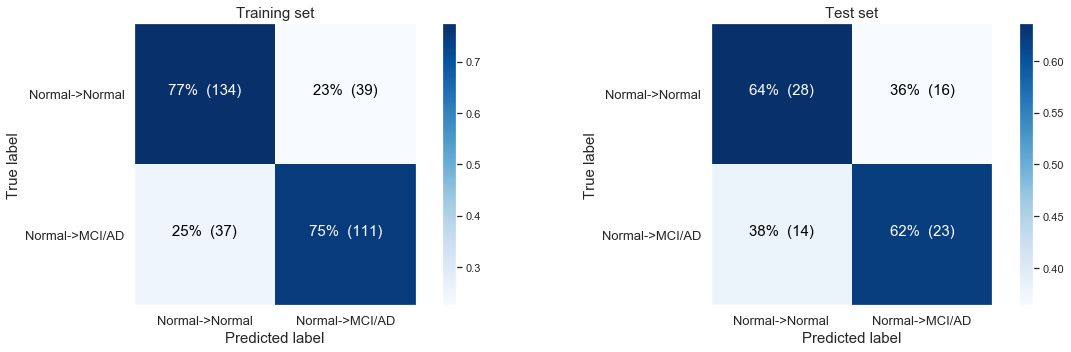

In [24]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2.values, y_train2)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t{:.2f}\n'.format(baseline_logreg_2.score(X_train2.values, y_train2), baseline_logreg_2.score(X_test2.values, y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2.values))
cnf_matrix_ts = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

1. M: 			 Months after BL
2. RAVLT_perc_forget: 	 Percentage forgetting during Reys Auditory Verbal Learning Test
3. FAQ_bl: 		 Functinoal Activities Questionnaire score at BL



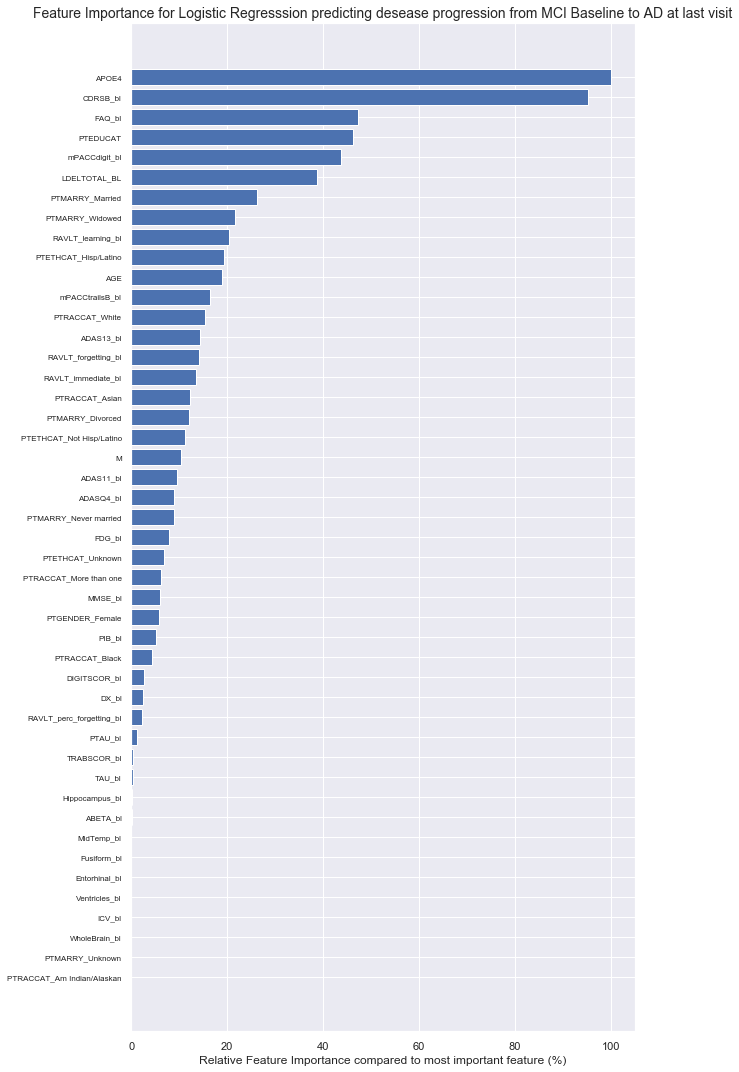

In [25]:
# Feature importance analysis, sort and visualization (for MCI baseline model)
print('1. M: \t\t\t Months after BL')
print('2. RAVLT_perc_forget: \t Percentage forgetting during Reys Auditory Verbal Learning Test')
print('3. FAQ_bl: \t\t Functinoal Activities Questionnaire score at BL\n')

feature_importance = abs(baseline_logreg_2.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train2.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
plt.tight_layout()   

# 3 Advanced Model Testing with 4-fold Cross Validation Scoring Reporting with internal CV parameter optimization within training fold

### 3.1 Parameter Optimisation and Cross Validation

- Parameters were optimised by a grid search on specific parameter values using a 3-fold cross-validation on the 75 percent training cohort to determine which parameter values led to the best performance. 
- For quantification of this 3-fold cross-validation (CV) the accuracy was used as the scoring function. 
- After this three-fold CV, the best set of parameters was used to train a model on the full 75% training set, and this model was validated on the remaining 25% percent test cohort.
- At the end we present the average and standard deviation of the accuracy, precision, recall, sensitivity, AUROC etc. of these 4 outer Cross Validations.

**Cross-validation setting:** 
- 4-fold cross validation ( so averages on these 4 test sets will be reported )
- Within every training fold of cross validation we do an internal 3-fold CV to optimise the parameters

**Illustrated example of Parameter Optimization:**
- Model:
 - LogisticRegression(random_state = 1, solver = 'liblinear', class_weight = 'balanced')
- Tested Estimator_parameters 
 - 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [26]:
X_CV=X_2
y_CV=y_2

In [27]:
Estimator_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

In [28]:
# All 10 parameter optimisations and cross validations of a certain Classifier
# Split the data randomly (stratified) in 10 folds
splits = 4
print("All {} PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE \"KNeighborsClassifier\" ALGORITHM".format(splits))
strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)

params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
total_params= np.prod(params)

best_index=[]
Sum=[0]*total_params
AP_Score =np.array([])
ROC_Score =np.array([])
Prec_Score =np.array([])
Recall_Score =np.array([])
F1_Score =np.array([])
Sens_Score =np.array([])
Spec_Score =np.array([])
Accuracy_Score =np.array([])

best_predictions_all=np.array([])
test_all=np.array([])
i=0
for train_index_external, test_index_external in splitted_indexes_external:
    i+=1
    print("\nThis is optimisation and CV number {}  \t----------------------------------------------------------------------------".format(i))
    
    # take i’th fold as test set and the other 3 folds together as training set
    X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
    y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
    # take the training set and split it randomly (stratified) 
    # in an inner training set of 2/3 size and an inner validation set of 1/3 size
        
    # for each of the ML methods
    # for each combination of parameter values
    # train the ML method with specified parameters on inner training set and validate on inner validation set
    # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
    # also write down this parameter value combination train the ML method with best parameter values on
    # the (outer) training set and test on the (outer) test set
                
    mod=clone(Estimator)
    optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='accuracy')
    optimisation_param_AP.fit(X_train, y_train)
    print('Mean scores: \t\t\t\t{}'.format((optimisation_param_AP.cv_results_['mean_test_score']).round(4)))
    print('Differences best - other scores:\t{}'.format((optimisation_param_AP.best_score_-optimisation_param_AP.cv_results_['mean_test_score']).round(4)))
    print('The best paremeters set was\t \tSet {}: {}'.format(optimisation_param_AP.best_index_ +1, optimisation_param_AP.best_params_))
    best_index.append(optimisation_param_AP.best_index_+1)
    Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)
    
    # Building Random Forest Estimator with best parameters
    best= optimisation_param_AP.best_estimator_
    best.fit(X_train, y_train)
    best_predictions = best.predict_proba(X_test)[:,1]
    best_predictions=best_predictions
    Average_precision_score=average_precision_score(y_test, best_predictions)
    best_predictions_binary =  best.predict(X_test)
    t=confusion_matrix(y_test, best_predictions_binary)
    sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
    specificity=(t[0][0]/(t[0][1]+t[0][0]))
    AP_Score =np.append(AP_Score , Average_precision_score)
    ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
    Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
    Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
    F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
    Sens_Score =np.append(Sens_Score , sensitivity)
    Spec_Score =np.append(Spec_Score , specificity)
    Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))
    
    best_predictions_all=np.append(best_predictions_all,best_predictions)
    test_all=np.append(test_all,y_test)
    print('Validation Accuracy score: \t\t{}'.format(Accuracy_Score .round(2)))

All 4 PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE "KNeighborsClassifier" ALGORITHM

This is optimisation and CV number 1  	----------------------------------------------------------------------------
Mean scores: 				[0.7133 0.71   0.72   0.71   0.72   0.71   0.7133]
Differences best - other scores:	[0.0067 0.01   0.     0.01   0.     0.01   0.0067]
The best paremeters set was	 	Set 3: {'C': 0.1}
Validation Accuracy score: 		[0.69]

This is optimisation and CV number 2  	----------------------------------------------------------------------------
Mean scores: 				[0.7086 0.7086 0.6954 0.6887 0.6954 0.6887 0.7152]
Differences best - other scores:	[0.0066 0.0066 0.0199 0.0265 0.0199 0.0265 0.    ]
The best paremeters set was	 	Set 7: {'C': 1000}
Validation Accuracy score: 		[0.69 0.73]

This is optimisation and CV number 3  	----------------------------------------------------------------------------
Mean scores: 				[0.6788 0.6921 0.6854 0.6821 0.6987 0.6821 0.6821]
Differences

Here we see a print of all the 4 Cross validations, the accuracy scores with also the best set of paremeters in this run. We see that with every CV run we add a value of the outer validation accuaracy to the last list that is printed.

In [29]:
print('____________________________________________________________________________________________________________________\n') 
Avg=Sum/splits
print('Average of {} splits mean_test_score for all 8 parameter sets:\n{}'.format(splits, Avg.round(2)))
print('Differences best Average - Average for all 8 parameter sets:\n{}'.format((Avg.max()-Avg).round(2)))
print('Best Average mean_test_score = {} for the {}th parameter: {}'.format(round(Avg.max(),2), Avg.argmax()+1, optimisation_param_AP.cv_results_['params'][Avg.argmax()]))
print('Best Parameter Set for all {} splits: {}'.format(splits,best_index))
print('Occurences of all 8 parameters as Best Parameter Set in a split: {}'.format(Counter(best_index)))

____________________________________________________________________________________________________________________

Average of 4 splits mean_test_score for all 8 parameter sets:
[0.7 0.7 0.7 0.7 0.7 0.7 0.7]
Differences best Average - Average for all 8 parameter sets:
[0.01 0.   0.   0.01 0.   0.01 0.01]
Best Average mean_test_score = 0.7 for the 2th parameter: {'C': 0.01}
Best Parameter Set for all 4 splits: [3, 7, 5, 2]
Occurences of all 8 parameters as Best Parameter Set in a split: Counter({3: 1, 7: 1, 5: 1, 2: 1})


After the for runs of cross validation and parameter optimization we see that our second parameter $C=0.01$ is performing the best. It has the best mean test score from all the tested values for $C=[0.001,0.01,0.1,1,10,100,1000]$ that were tested.

### 3.2 Model Performance and Area Under The Receiver Operating Characteristic Curve

In [30]:
print('____________________________________________________________________________________________________________________\n') 
print('Estimator : All {} Accuracy Scores of validation on the outer test set with\nthe estimator with the optimised parameters trained on the inner test set: \n\n{}'.format(splits, Accuracy_Score))
print('\n\t\tAvg \t(+- STD  )\n\t\t-----------------\nAccuracy: \t{} \t(+- {}) '.format(round(Accuracy_Score.mean(),3), round(Accuracy_Score.std(),3)))

____________________________________________________________________________________________________________________

Estimator : All 4 Accuracy Scores of validation on the outer test set with
the estimator with the optimised parameters trained on the inner test set: 

[0.68627451 0.73       0.72       0.7       ]

		Avg 	(+- STD  )
		-----------------
Accuracy: 	0.709 	(+- 0.017) 


In [31]:
d={}
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['Logistic_mu'] = [AP_Score.mean(), ROC_Score.mean(), Prec_Score.mean(), Recall_Score.mean(), F1_Score.mean(), Sens_Score.mean(), Spec_Score.mean(), Accuracy_Score.mean()]
d['Logistic_std'] = [AP_Score.std(), ROC_Score.std(), Prec_Score.std(), Recall_Score.std(), F1_Score.std(), Sens_Score.std(), Spec_Score.std(), Accuracy_Score.std()]
df = pd.DataFrame(data=d, index=Names)
#decimals = pd.Series([2, 3], index=['Logistic_mu', 'Logistic_std'])
#df.round(decimals)
df.round(2)

,Logistic_mu,Logistic_std
Average Precision,0.76,0.02
AUROC,0.78,0.01
Precision,0.68,0.03
Recall,0.70,0.08
F1_Score,0.69,0.03
Sensitivity,0.70,0.08
Specificity,0.72,0.06
Accuracy,0.71,0.02


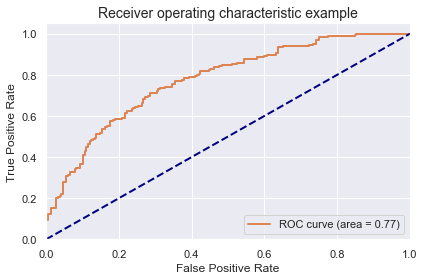

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(test_all[:], best_predictions_all[:])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='C1', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.tight_layout()

### The actual Parameter Optimisation and 5-fold CV wrapped in a function

In [33]:
def CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters):
  # All 10 parameter optimisations and cross validations of a certain Classifier
  strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
  splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)
  params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
  total_params= np.prod(params)
  best_index=[]
  Sum=[0]*total_params
  AP_Score =np.array([])
  ROC_Score =np.array([])
  Prec_Score =np.array([])
  Recall_Score =np.array([])
  F1_Score =np.array([])
  Sens_Score =np.array([])
  Spec_Score =np.array([])
  Accuracy_Score =np.array([])

  best_predictions_all=np.array([])
  test_all=np.array([])
  i=1
  for train_index_external, test_index_external in splitted_indexes_external:
      print("This is parameter optimisation and CV number {} ... \t{}".format(i, Accuracy_Score))
      i=i+1
      # take i’th fold as test set and the other 3 folds together as training set
      X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
      y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
      # take the training set and split it randomly (stratified) 
      # in an inner training set of 2/3 size and an inner validation set of 1/3 size

      # for each of the ML methods
      # for each combination of parameter values
      # train the ML method with specified parameters on inner training set and validate on inner validation set
      # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
      # also write down this parameter value combination train the ML method with best parameter values on
      # the (outer) training set and test on the (outer) test set

      mod=clone(Estimator)
      optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='accuracy')
      optimisation_param_AP.fit(X_train, y_train)
      best_index.append(optimisation_param_AP.best_index_+1)
      Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)

      # Building Estimator with best parameters
      best= optimisation_param_AP.best_estimator_
      best.fit(X_train, y_train)
      best_predictions = best.predict_proba(X_test)[:,1]
      best_predictions=best_predictions
      Average_precision_score=average_precision_score(y_test, best_predictions)
      best_predictions_binary =  best.predict(X_test)
      t=confusion_matrix(y_test, best_predictions_binary)
      sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
      specificity=(t[0][0]/(t[0][1]+t[0][0]))
      AP_Score =np.append(AP_Score , Average_precision_score)
      ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
      Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
      Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
      F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
      Sens_Score =np.append(Sens_Score , sensitivity)
      Spec_Score =np.append(Spec_Score , specificity)
      Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))

      best_predictions_all=np.append(best_predictions_all,best_predictions)
      test_all=np.append(test_all,y_test)
  
  print('Done: Validation Accuracy score: \t\t\t{}'.format(Accuracy_Score .round(3)))
  return AP_Score,  ROC_Score,  Prec_Score,  Recall_Score,  F1_Score,  Sens_Score, Spec_Score, Accuracy_Score,  best_predictions_all, test_all

In [34]:
Estimator_parameters = {'C':[0.1, 0.5, 1, 10, 20] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.69607843]
This is parameter optimisation and CV number 3 ... 	[0.69607843 0.73      ]
This is parameter optimisation and CV number 4 ... 	[0.69607843 0.73       0.72      ]
Done: Validation Accuracy score: 			[0.696 0.73  0.72  0.72 ]


In [35]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['0 Logistic_mu_default'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean()]
d['a Logistic_std_default'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,0 Logistic_mu_default,a Logistic_std_default
Average Precision,0.75,0.01
AUROC,0.78,0.01
Precision,0.69,0.03
Recall,0.71,0.07
F1_Score,0.70,0.02
Sensitivity,0.71,0.07
Specificity,0.72,0.06
Accuracy,0.72,0.01


## 3.3 Model Performance testing for Baseline patients progressing to MCI or AD.

**Paramater optimization and CV for the following tested algorithms:**

- KNN
- Logistic Regression
- Decision Tree Classifier
- Random Forest
- Gradient Boosting
- XGBoost
- Multi-layer Perceptron
- Light-GBM

#### 3.3.1 KNN 
``` class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
 leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)````

Test parameters:
- n_neighbors: 1, 3, 5, 9
- p: 1, 2 (manhattan and euclidean distance)

In [36]:
# X_1 and y_1 are people with baseline normal Diagnosis
X_CV  = X_1 
y_CV  = y_1

# Scaling to a 0 to 1 scale
X_std = (X_CV - X_CV.min(axis=0)) / (X_CV.max(axis=0) - X_CV.min(axis=0))
X_CV  = X_std.dropna(axis=1).copy()

KNN_parameters = {'p':[1,2], 'n_neighbors':[1, 3, 5, 9]}
KNN = KNeighborsClassifier(weights='distance')

In [37]:
KNN_AP,  KNN_ROC,  KNN_Prec,  KNN_Recall,  KNN_F1,  KNN_Sens, KNN_Spec, \
KNN_Accuracy,  KNN_best_predictions_all,  KNN_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, KNN, KNN_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.77586207]
This is parameter optimisation and CV number 3 ... 	[0.77586207 0.78947368]
This is parameter optimisation and CV number 4 ... 	[0.77586207 0.78947368 0.73684211]
Done: Validation Accuracy score: 			[0.776 0.789 0.737 0.754]


In [38]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['1 KNN_mu'] = [KNN_AP.mean(),  KNN_ROC.mean(),  KNN_Prec.mean(),  KNN_Recall.mean(),  KNN_F1.mean(),  KNN_Sens.mean(), KNN_Spec.mean(), KNN_Accuracy.mean()]
d['1 KNN_std'] = [KNN_AP.std(),  KNN_ROC.std(),  KNN_Prec.std(),  KNN_Recall.std(),  KNN_F1.std(),  KNN_Sens.std(), KNN_Spec.std(), KNN_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std
Average Precision,0.31,0.06
AUROC,0.52,0.03
Precision,0.58,0.43
Recall,0.06,0.03
F1_Score,0.10,0.06
Sensitivity,0.06,0.03
Specificity,0.98,0.02
Accuracy,0.76,0.02


#### 3.3.2 Logistic Regression
```class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001,  C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,  solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)```

Test parameters:
- solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
- C: 0.001,0.01,0.1,1,10,100,1000 


In [39]:
LOGI_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
LOGI =LogisticRegression(random_state=1,max_iter=1000,tol=5e-4, solver='liblinear', class_weight='balanced')

In [40]:
LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, LOGI, LOGI_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.72413793]
This is parameter optimisation and CV number 3 ... 	[0.72413793 0.80701754]
This is parameter optimisation and CV number 4 ... 	[0.72413793 0.80701754 0.56140351]
Done: Validation Accuracy score: 			[0.724 0.807 0.561 0.684]


In [41]:
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['2 LOGI_mu'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean()]
d['2 LOGI_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std
Average Precision,0.31,0.06,0.44,0.09
AUROC,0.52,0.03,0.72,0.09
Precision,0.58,0.43,0.41,0.12
Recall,0.06,0.03,0.60,0.15
F1_Score,0.10,0.06,0.48,0.12
Sensitivity,0.06,0.03,0.60,0.15
Specificity,0.98,0.02,0.72,0.09
Accuracy,0.76,0.02,0.69,0.09


#### 3.3.3 SVM
``` class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None) ```

Test parameters:
-  C: 0.001,0.01,0.1,1,10,100,1000 
- gamma = 0.001,0.01,0.1,1

In [42]:
SVC_parameters = {'C':[0.1,1,10], 'gamma':[0.01,0.1,1] }
svc=SVC(probability=True,random_state=1,class_weight='balanced', cache_size=20000,kernel='rbf')

In [43]:
SVC_AP,  SVC_ROC,  SVC_Prec,  SVC_Recall,  SVC_F1,  SVC_Sens, SVC_Spec, \
SVC_Accuracy,  SVC_best_predictions_all,  SVC_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, svc, SVC_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.70689655]
This is parameter optimisation and CV number 3 ... 	[0.70689655 0.78947368]
This is parameter optimisation and CV number 4 ... 	[0.70689655 0.78947368 0.64912281]
Done: Validation Accuracy score: 			[0.707 0.789 0.649 0.737]


In [44]:
d['3 SVC_mu'] = [SVC_AP.mean(),  SVC_ROC.mean(),  SVC_Prec.mean(),  SVC_Recall.mean(),  SVC_F1.mean(),  SVC_Sens.mean(), SVC_Spec.mean(), SVC_Accuracy.mean()]
d['3 SVC_std'] = [SVC_AP.std(),  SVC_ROC.std(),  SVC_Prec.std(),  SVC_Recall.std(),  SVC_F1.std(),  SVC_Sens.std(), SVC_Spec.std(), SVC_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

SVC never converges...


#### 3.3.4 Decision Tree
```class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)```

Test parameters:
- max depth = 2, 3, 4, ..., 13, 14, 15

In [45]:
TREE_parameters ={ 'max_depth':range(2,15,2) }    
TREE = DecisionTreeClassifier(random_state=1)

In [46]:
TREE_AP,  TREE_ROC,  TREE_Prec,  TREE_Recall,  TREE_F1,  TREE_Sens, TREE_Spec, \
TREE_Accuracy,  TREE_best_predictions_all,  TREE_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, TREE, TREE_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.70689655]
This is parameter optimisation and CV number 3 ... 	[0.70689655 0.75438596]
This is parameter optimisation and CV number 4 ... 	[0.70689655 0.75438596 0.70175439]
Done: Validation Accuracy score: 			[0.707 0.754 0.702 0.667]


In [47]:
d['4 TREE_mu'] = [TREE_AP.mean(),  TREE_ROC.mean(),  TREE_Prec.mean(),  TREE_Recall.mean(),  TREE_F1.mean(),  TREE_Sens.mean(), TREE_Spec.mean(), TREE_Accuracy.mean()]
d['4 TREE_std'] = [TREE_AP.std(),  TREE_ROC.std(),  TREE_Prec.std(),  TREE_Recall.std(),  TREE_F1.std(),  TREE_Sens.std(), TREE_Spec.std(), TREE_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03


#### 3.3.5 Random Forest

```class sklearn.ensemble.RandomForestClassifier(n_estimators=10->100, criterion='gini', 
max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)```

Test parameters:
- n_estimators: 50, 100, 500
- max_features: sqrt(#features), log2(#features):
    #If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    #If “log2”, then max_features=log2(n_features).
- min_samples_leaf: 1, 5

In [48]:
RF_parameters = {'n_estimators':[50, 100, 500], 'max_features':('sqrt', 'log2'), 'min_samples_leaf':[1, 5]}
RF = RandomForestClassifier(random_state=1)

In [49]:
RF_AP,  RF_ROC,  RF_Prec,  RF_Recall,  RF_F1,  RF_Sens, RF_Spec, \
RF_Accuracy,  RF_best_predictions_all,  RF_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, RF, RF_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.74137931]
This is parameter optimisation and CV number 3 ... 	[0.74137931 0.77192982]
This is parameter optimisation and CV number 4 ... 	[0.74137931 0.77192982 0.70175439]
Done: Validation Accuracy score: 			[0.741 0.772 0.702 0.754]


In [50]:
d['5 RF_mu'] = [RF_AP.mean(),  RF_ROC.mean(),  RF_Prec.mean(),  RF_Recall.mean(),  RF_F1.mean(),  RF_Sens.mean(), RF_Spec.mean(), RF_Accuracy.mean()]
d['5 RF_std'] = [RF_AP.std(),  RF_ROC.std(),  RF_Prec.std(),  RF_Recall.std(),  RF_F1.std(),  RF_Sens.std(), RF_Spec.std(), RF_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02,0.36,0.10
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02,0.61,0.07
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08,0.10,0.17
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08,0.06,0.10
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05,0.95,0.04
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03,0.74,0.03



#### 3.3.6 Gradient boosting
``` class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
 max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')```

Test parameters:
- n_estimators: 50, 100, 500 
- max_leaf_nodes= 2, 4, 8, 16 
- learning_rate = 1, 0.5, 0.1, 0.05, 0.01

In [51]:
BOOST_parameters = {'n_estimators':[50,100,500],'max_leaf_nodes':[2,4,8,16],'learning_rate':[1, 0.5, 0.1, 0.05, 0.01]}
BOOST=GradientBoostingClassifier(random_state=1)

In [52]:
BOOST_AP,  BOOST_ROC,  BOOST_Prec,  BOOST_Recall,  BOOST_F1,  BOOST_Sens, BOOST_Spec, \
BOOST_Accuracy,  BOOST_best_predictions_all,  BOOST_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, BOOST, BOOST_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.74137931]
This is parameter optimisation and CV number 3 ... 	[0.74137931 0.80701754]
This is parameter optimisation and CV number 4 ... 	[0.74137931 0.80701754 0.63157895]
Done: Validation Accuracy score: 			[0.741 0.807 0.632 0.772]


In [53]:
d['6 BOOST_mu'] = [BOOST_AP.mean(),  BOOST_ROC.mean(),  BOOST_Prec.mean(),  BOOST_Recall.mean(),  BOOST_F1.mean(),  BOOST_Sens.mean(), BOOST_Spec.mean(), BOOST_Accuracy.mean()]
d['6 BOOST_std'] = [BOOST_AP.std(),  BOOST_ROC.std(),  BOOST_Prec.std(),  BOOST_Recall.std(),  BOOST_F1.std(),  BOOST_Sens.std(), BOOST_Spec.std(), BOOST_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02,0.36,0.10,0.45,0.16
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02,0.61,0.07,0.68,0.10
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08,0.10,0.17,0.27,0.31
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08,0.06,0.10,0.12,0.14
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05,0.95,0.04,0.94,0.07
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03,0.74,0.03,0.74,0.07


#### 3.3.7. XGBoost
 ``` class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)```

Bases: xgboost.sklearn.XGBModel, object
Implementation of the scikit-learn API for XGBoost classification.

Test parameters:
- max_depth = 3,4,...,9,10 
- min_child_weight =  1,3  
- gamma = [0, 0.1,0.2]
- subsample = 0.6, 0,8 
- colsample_bytree = 0.6, 0,8 
- reg_alpha = [0, 0.005, 0.01, 0.05]

In [54]:
XGB2_parameters ={ 'max_depth':range(3,10,2),'min_child_weight':range(1,3,2),
                   'gamma':[0, 0.1,0.2],'subsample':[i/10.0 for i in range(6,9,2)],
                   'colsample_bytree':[i/10.0 for i in range(6,9,2)], 'reg_alpha':[0, 0.005, 0.01, 0.05]}    
XGB2 = XGBClassifier(random_state=1)

In [56]:
XGB2_AP,  XGB2_ROC,  XGB2_Prec,  XGB2_Recall,  XGB2_F1,  XGB2_Sens, XGB2_Spec, \
XGB2_Accuracy,  XGB2_best_predictions_all,  XGB2_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, XGB2, XGB2_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.72413793]
This is parameter optimisation and CV number 3 ... 	[0.72413793 0.78947368]
This is parameter optimisation and CV number 4 ... 	[0.72413793 0.78947368 0.64912281]
Done: Validation Accuracy score: 			[0.724 0.789 0.649 0.737]


In [57]:
d['7 XGB2_mu'] = [XGB2_AP.mean(),  XGB2_ROC.mean(),  XGB2_Prec.mean(),  XGB2_Recall.mean(),  XGB2_F1.mean(),  XGB2_Sens.mean(), XGB2_Spec.mean(), XGB2_Accuracy.mean()]
d['7 XGB2_std'] = [XGB2_AP.std(),  XGB2_ROC.std(),  XGB2_Prec.std(),  XGB2_Recall.std(),  XGB2_F1.std(),  XGB2_Sens.std(), XGB2_Spec.std(), XGB2_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02,0.36,0.10,0.45,0.16,0.36,0.09
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02,0.61,0.07,0.68,0.10,0.63,0.09
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08,0.10,0.17,0.27,0.31,0.44,0.33
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08,0.06,0.10,0.12,0.14,0.16,0.04
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05,0.95,0.04,0.94,0.07,0.91,0.07
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03,0.74,0.03,0.74,0.07,0.72,0.05


#### 3.3.8 MLP

```class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)```

Test parameters:
- hidden_layer_sizes: (3, ), (20, ), (50, ), (100, )
- activation: relu, logistic
- alpha = 0.00001, 0.0001, 0.001, 0.09, 0.1, 0.5 and 0.9 (assuming this is the decay parameter in Weng et al)

In [58]:
MLP_parameters = {'activation':('relu', 'logistic'), 'hidden_layer_sizes':[(3, ),(20, ),(20,20 ),(50, ),(50,50 ),(100, )],
                 'alpha':[0.0001,0.001,0.09,0.1,0.5]}
MLP = MLPClassifier(random_state=1, max_iter=500,solver='adam')
# It will give warnings without the increase of the standard max_iterations (200) to 2000
# Tolerance softening from standard tol (1e-4) to (2e-4)

In [59]:
MLP_AP,  MLP_ROC,  MLP_Prec,  MLP_Recall,  MLP_F1,  MLP_Sens, MLP_Spec, \
MLP_Accuracy,  MLP_best_predictions_all,  MLP_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, MLP, MLP_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.72413793]
This is parameter optimisation and CV number 3 ... 	[0.72413793 0.77192982]
This is parameter optimisation and CV number 4 ... 	[0.72413793 0.77192982 0.63157895]
Done: Validation Accuracy score: 			[0.724 0.772 0.632 0.772]


In [60]:
d['8 MLP_mu'] = [MLP_AP.mean(),  MLP_ROC.mean(),  MLP_Prec.mean(),  MLP_Recall.mean(),  MLP_F1.mean(),  MLP_Sens.mean(), MLP_Spec.mean(), MLP_Accuracy.mean()]
d['8 MLP_std'] = [MLP_AP.std(),  MLP_ROC.std(),  MLP_Prec.std(),  MLP_Recall.std(),  MLP_F1.std(),  MLP_Sens.std(), MLP_Spec.std(), MLP_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02,0.36,0.10,0.45,0.16,0.36,0.09,0.39,0.07
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02,0.61,0.07,0.68,0.10,0.63,0.09,0.63,0.05
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08,0.10,0.17,0.27,0.31,0.44,0.33,0.28,0.18
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04,0.15,0.12
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08,0.06,0.10,0.12,0.14,0.16,0.04,0.17,0.11
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04,0.15,0.12
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05,0.95,0.04,0.94,0.07,0.91,0.07,0.90,0.11
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03,0.74,0.03,0.74,0.07,0.72,0.05,0.72,0.06


#### 3.3.9 LGBM

```class lightgbm.Dataset(data, label=None, reference=None, weight=None, group=None, init_score=None, silent=False, feature_name='auto', categorical_feature='auto', params=None, free_raw_data=True)```

Test parameters:
- max_depth = 2, 3, 4, 5, 6, 7, 8, 9,10, 30
- n_estimators = 5, 25, 50

In [61]:
LGBM_params = {'max_depth' : [2,3,4,5,6,7,8,9,10, 30],
                'n_estimators': [5, 25, 50]}
lgbm=LGBMClassifier(random_state=1)

In [62]:
LGBM_AP,  LGBM_ROC,  LGBM_Prec,  LGBM_Recall,  LGBM_F1,  LGBM_Sens, LGBM_Spec, \
LGBM_Accuracy,  LGBM_best_predictions_all,  LGBM_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, lgbm, LGBM_params)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.75862069]
This is parameter optimisation and CV number 3 ... 	[0.75862069 0.77192982]
This is parameter optimisation and CV number 4 ... 	[0.75862069 0.77192982 0.70175439]
Done: Validation Accuracy score: 			[0.759 0.772 0.702 0.772]


In [63]:
d['9 LGBM_mu'] = [LGBM_AP.mean(),  LGBM_ROC.mean(),  LGBM_Prec.mean(),  LGBM_Recall.mean(),  LGBM_F1.mean(),  LGBM_Sens.mean(), LGBM_Spec.mean(), LGBM_Accuracy.mean()]
d['9 LGBM_std'] = [LGBM_AP.std(),  LGBM_ROC.std(),  LGBM_Prec.std(),  LGBM_Recall.std(),  LGBM_F1.std(),  LGBM_Sens.std(), LGBM_Spec.std(), LGBM_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df_normal_to_MCI_AD = df.copy()
df_normal_to_MCI_AD.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std,9 LGBM_mu,9 LGBM_std
Average Precision,0.31,0.06,0.44,0.09,0.32,0.05,0.28,0.02,0.36,0.10,0.45,0.16,0.36,0.09,0.39,0.07,0.39,0.06
AUROC,0.52,0.03,0.72,0.09,0.58,0.02,0.58,0.02,0.61,0.07,0.68,0.10,0.63,0.09,0.63,0.05,0.69,0.03
Precision,0.58,0.43,0.41,0.12,0.45,0.32,0.33,0.08,0.10,0.17,0.27,0.31,0.44,0.33,0.28,0.18,0.06,0.11
Recall,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04,0.15,0.12,0.04,0.07
F1_Score,0.10,0.06,0.48,0.12,0.19,0.07,0.27,0.08,0.06,0.10,0.12,0.14,0.16,0.04,0.17,0.11,0.05,0.08
Sensitivity,0.06,0.03,0.60,0.15,0.15,0.10,0.24,0.09,0.04,0.07,0.08,0.09,0.11,0.04,0.15,0.12,0.04,0.07
Specificity,0.98,0.02,0.72,0.09,0.89,0.09,0.85,0.05,0.95,0.04,0.94,0.07,0.91,0.07,0.90,0.11,0.97,0.06
Accuracy,0.76,0.02,0.69,0.09,0.72,0.05,0.71,0.03,0.74,0.03,0.74,0.07,0.72,0.05,0.72,0.06,0.75,0.03


## 3.4 Model Performance testing for MCI patients progressing to AD.

**Paramater optimization and CV for the following tested algorithms:**

- KNN
- Logistic Regression
- Decision Tree Classifier
- Random Forest
- Gradient Boosting
- XGBoost
- Multi-layer Perceptron
- Light-GBM

#### 3.4.1 KNN 
``` class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
 leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)````

Test parameters:
- n_neighbors: 1, 3, 5, 9
- p: 1, 2 (manhattan and euclidean distance): *Note: manhattan distance based on the grid-like streets of New York*

In [64]:
# X_1 and y_1 are people with baseline normal Diagnosis
X_CV  = X_2
y_CV  = y_2

# Scaling to a 0 to 1 scale
X_std = (X_CV - X_CV.min(axis=0)) / (X_CV.max(axis=0) - X_CV.min(axis=0))
X_CV  = X_std.dropna(axis=1).copy()

KNN_parameters = {'p':[1,2], 'n_neighbors':[1, 3, 5, 9]}
KNN = KNeighborsClassifier(weights='distance')

In [65]:
KNN_AP,  KNN_ROC,  KNN_Prec,  KNN_Recall,  KNN_F1,  KNN_Sens, KNN_Spec, \
KNN_Accuracy,  KNN_best_predictions_all,  KNN_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, KNN, KNN_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.67647059]
This is parameter optimisation and CV number 3 ... 	[0.67647059 0.68      ]
This is parameter optimisation and CV number 4 ... 	[0.67647059 0.68       0.76      ]
Done: Validation Accuracy score: 			[0.676 0.68  0.76  0.69 ]


In [66]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['1 KNN_mu'] = [KNN_AP.mean(),  KNN_ROC.mean(),  KNN_Prec.mean(),  KNN_Recall.mean(),  KNN_F1.mean(),  KNN_Sens.mean(), KNN_Spec.mean(), KNN_Accuracy.mean()]
d['1 KNN_std'] = [KNN_AP.std(),  KNN_ROC.std(),  KNN_Prec.std(),  KNN_Recall.std(),  KNN_F1.std(),  KNN_Sens.std(), KNN_Spec.std(), KNN_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std
Average Precision,0.69,0.05
AUROC,0.76,0.06
Precision,0.67,0.07
Recall,0.74,0.07
F1_Score,0.70,0.02
Sensitivity,0.74,0.07
Specificity,0.67,0.11
Accuracy,0.70,0.03


#### 3.4.2 Logistic Regression
```class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001,  C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,  solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)```

Test parameters:
- solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
- C: 0.001,0.01,0.1,1,10,100,1000 


In [67]:
LOGI_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
LOGI =LogisticRegression(random_state=1,max_iter=1000,tol=5e-4, solver='liblinear', class_weight='balanced')

In [68]:
LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, LOGI, LOGI_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.62745098]
This is parameter optimisation and CV number 3 ... 	[0.62745098 0.66      ]
This is parameter optimisation and CV number 4 ... 	[0.62745098 0.66       0.72      ]
Done: Validation Accuracy score: 			[0.627 0.66  0.72  0.71 ]


In [69]:
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['2 LOGI_mu'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean()]
d['2 LOGI_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std
Average Precision,0.69,0.05,0.74,0.05
AUROC,0.76,0.06,0.77,0.04
Precision,0.67,0.07,0.65,0.06
Recall,0.74,0.07,0.71,0.09
F1_Score,0.70,0.02,0.67,0.03
Sensitivity,0.74,0.07,0.71,0.09
Specificity,0.67,0.11,0.65,0.12
Accuracy,0.70,0.03,0.68,0.04


#### 3.4.3 SVM
``` class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None) ```

Test parameters:
-  C: 0.001,0.01,0.1,1,10,100,1000 
- gamma = 0.001,0.01,0.1,1

In [70]:
SVC_parameters = {'C':[0.1,1,10], 'gamma':[0.01,0.1,1] }
svc=SVC(probability=True,random_state=1,class_weight='balanced', cache_size=20000,kernel='rbf')

In [71]:
SVC_AP,  SVC_ROC,  SVC_Prec,  SVC_Recall,  SVC_F1,  SVC_Sens, SVC_Spec, \
SVC_Accuracy,  SVC_best_predictions_all,  SVC_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, svc, SVC_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.71568627]
This is parameter optimisation and CV number 3 ... 	[0.71568627 0.67      ]
This is parameter optimisation and CV number 4 ... 	[0.71568627 0.67       0.73      ]
Done: Validation Accuracy score: 			[0.716 0.67  0.73  0.71 ]


In [78]:
d['3 SVC_mu'] = [SVC_AP.mean(),  SVC_ROC.mean(),  SVC_Prec.mean(),  SVC_Recall.mean(),  SVC_F1.mean(),  SVC_Sens.mean(), SVC_Spec.mean(), SVC_Accuracy.mean()]
d['3 SVC_std'] = [SVC_AP.std(),  SVC_ROC.std(),  SVC_Prec.std(),  SVC_Recall.std(),  SVC_F1.std(),  SVC_Sens.std(), SVC_Spec.std(), SVC_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03


#### 3.4.4 Decision Tree
```class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)```

Test parameters:
- max depth = 2, 3, 4, ..., 13, 14, 15

In [79]:
TREE_parameters ={ 'max_depth':range(2,15,2) }    
TREE = DecisionTreeClassifier(random_state=1)

In [80]:
TREE_AP,  TREE_ROC,  TREE_Prec,  TREE_Recall,  TREE_F1,  TREE_Sens, TREE_Spec, \
TREE_Accuracy,  TREE_best_predictions_all,  TREE_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, TREE, TREE_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.64705882]
This is parameter optimisation and CV number 3 ... 	[0.64705882 0.68      ]
This is parameter optimisation and CV number 4 ... 	[0.64705882 0.68       0.61      ]
Done: Validation Accuracy score: 			[0.647 0.68  0.61  0.61 ]


In [81]:
d['4 TREE_mu'] = [TREE_AP.mean(),  TREE_ROC.mean(),  TREE_Prec.mean(),  TREE_Recall.mean(),  TREE_F1.mean(),  TREE_Sens.mean(), TREE_Spec.mean(), TREE_Accuracy.mean()]
d['4 TREE_std'] = [TREE_AP.std(),  TREE_ROC.std(),  TREE_Prec.std(),  TREE_Recall.std(),  TREE_F1.std(),  TREE_Sens.std(), TREE_Spec.std(), TREE_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03


#### 3.4.5 Random Forest

```class sklearn.ensemble.RandomForestClassifier(n_estimators=10->100, criterion='gini', 
max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)```

Test parameters:
- n_estimators: 50, 100, 500
- max_features: sqrt(#features), log2(#features):
    #If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    #If “log2”, then max_features=log2(n_features).
- min_samples_leaf: 1, 5

In [82]:
RF_parameters = {'n_estimators':[50, 100, 500], 'max_features':('sqrt', 'log2'), 'min_samples_leaf':[1, 5]}
RF = RandomForestClassifier(random_state=1)

In [83]:
RF_AP,  RF_ROC,  RF_Prec,  RF_Recall,  RF_F1,  RF_Sens, RF_Spec, \
RF_Accuracy,  RF_best_predictions_all,  RF_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, RF, RF_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.73529412]
This is parameter optimisation and CV number 3 ... 	[0.73529412 0.71      ]
This is parameter optimisation and CV number 4 ... 	[0.73529412 0.71       0.72      ]
Done: Validation Accuracy score: 			[0.735 0.71  0.72  0.69 ]


In [84]:
d['5 RF_mu'] = [RF_AP.mean(),  RF_ROC.mean(),  RF_Prec.mean(),  RF_Recall.mean(),  RF_F1.mean(),  RF_Sens.mean(), RF_Spec.mean(), RF_Accuracy.mean()]
d['5 RF_std'] = [RF_AP.std(),  RF_ROC.std(),  RF_Prec.std(),  RF_Recall.std(),  RF_F1.std(),  RF_Sens.std(), RF_Spec.std(), RF_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02



#### 3.4.6 Gradient boosting
``` class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
 max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')```

Test parameters:
- n_estimators: 50, 100, 500 
- max_leaf_nodes= 2, 4, 8, 16 
- learning_rate = 1, 0.5, 0.1, 0.05, 0.01

In [85]:
BOOST_parameters = {'n_estimators':[50,100,500],'max_leaf_nodes':[2,4,8,16],'learning_rate':[1, 0.5, 0.1, 0.05, 0.01]}
BOOST=GradientBoostingClassifier(random_state=1)

In [86]:
BOOST_AP,  BOOST_ROC,  BOOST_Prec,  BOOST_Recall,  BOOST_F1,  BOOST_Sens, BOOST_Spec, \
BOOST_Accuracy,  BOOST_best_predictions_all,  BOOST_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, BOOST, BOOST_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.74509804]
This is parameter optimisation and CV number 3 ... 	[0.74509804 0.68      ]
This is parameter optimisation and CV number 4 ... 	[0.74509804 0.68       0.75      ]
Done: Validation Accuracy score: 			[0.745 0.68  0.75  0.73 ]


In [87]:
d['6 BOOST_mu'] = [BOOST_AP.mean(),  BOOST_ROC.mean(),  BOOST_Prec.mean(),  BOOST_Recall.mean(),  BOOST_F1.mean(),  BOOST_Sens.mean(), BOOST_Spec.mean(), BOOST_Accuracy.mean()]
d['6 BOOST_std'] = [BOOST_AP.std(),  BOOST_ROC.std(),  BOOST_Prec.std(),  BOOST_Recall.std(),  BOOST_F1.std(),  BOOST_Sens.std(), BOOST_Spec.std(), BOOST_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02,0.78,0.05
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02,0.80,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04,0.71,0.05
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03,0.70,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07,0.75,0.07
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02,0.73,0.03


#### 3.4.7. XGBoost
 ``` class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)```

Bases: xgboost.sklearn.XGBModel, object
Implementation of the scikit-learn API for XGBoost classification.

Test parameters:
- max_depth = 3,4,...,9,10 
- min_child_weight =  1,3  
- gamma = [0, 0.1,0.2]
- subsample = 0.6, 0,8 
- colsample_bytree = 0.6, 0,8 
- reg_alpha = [0, 0.005, 0.01, 0.05]

In [88]:
XGB2_parameters ={ 'max_depth':range(3,10,2),'min_child_weight':range(1,3,2),
                   'gamma':[0, 0.1,0.2],'subsample':[i/10.0 for i in range(6,9,2)],
                   'colsample_bytree':[i/10.0 for i in range(6,9,2)], 'reg_alpha':[0, 0.005, 0.01, 0.05]}    
XGB2 = XGBClassifier(random_state=1)

In [89]:
XGB2_AP,  XGB2_ROC,  XGB2_Prec,  XGB2_Recall,  XGB2_F1,  XGB2_Sens, XGB2_Spec, \
XGB2_Accuracy,  XGB2_best_predictions_all,  XGB2_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, XGB2, XGB2_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.7254902]
This is parameter optimisation and CV number 3 ... 	[0.7254902 0.71     ]
This is parameter optimisation and CV number 4 ... 	[0.7254902 0.71      0.77     ]
Done: Validation Accuracy score: 			[0.725 0.71  0.77  0.71 ]


In [90]:
d['7 XGB2_mu'] = [XGB2_AP.mean(),  XGB2_ROC.mean(),  XGB2_Prec.mean(),  XGB2_Recall.mean(),  XGB2_F1.mean(),  XGB2_Sens.mean(), XGB2_Spec.mean(), XGB2_Accuracy.mean()]
d['7 XGB2_std'] = [XGB2_AP.std(),  XGB2_ROC.std(),  XGB2_Prec.std(),  XGB2_Recall.std(),  XGB2_F1.std(),  XGB2_Sens.std(), XGB2_Spec.std(), XGB2_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02


#### 3.4.8 MLP

```class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)```

Test parameters:
- hidden_layer_sizes: (3, ), (20, ), (50, ), (100, )
- activation: relu, logistic
- alpha = 0.00001, 0.0001, 0.001, 0.09, 0.1, 0.5 and 0.9 (assuming this is the decay parameter in Weng et al)

In [91]:
MLP_parameters = {'activation':('relu', 'logistic'), 'hidden_layer_sizes':[(3, ),(20, ),(20,20 ),(50, ),(50,50 ),(100, )],
                 'alpha':[0.0001,0.001,0.09,0.1,0.5]}
MLP = MLPClassifier(random_state=1, max_iter=500,solver='adam')
# It will give warnings without the increase of the standard max_iterations (200) to 2000
# Tolerance softening from standard tol (1e-4) to (2e-4)

In [92]:
MLP_AP,  MLP_ROC,  MLP_Prec,  MLP_Recall,  MLP_F1,  MLP_Sens, MLP_Spec, \
MLP_Accuracy,  MLP_best_predictions_all,  MLP_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, MLP, MLP_parameters)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.71568627]
This is parameter optimisation and CV number 3 ... 	[0.71568627 0.74      ]
This is parameter optimisation and CV number 4 ... 	[0.71568627 0.74       0.77      ]
Done: Validation Accuracy score: 			[0.716 0.74  0.77  0.68 ]


In [93]:
d['8 MLP_mu'] = [MLP_AP.mean(),  MLP_ROC.mean(),  MLP_Prec.mean(),  MLP_Recall.mean(),  MLP_F1.mean(),  MLP_Sens.mean(), MLP_Spec.mean(), MLP_Accuracy.mean()]
d['8 MLP_std'] = [MLP_AP.std(),  MLP_ROC.std(),  MLP_Prec.std(),  MLP_Recall.std(),  MLP_F1.std(),  MLP_Sens.std(), MLP_Spec.std(), MLP_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03


#### 3.4.9 LGBM

```class lightgbm.Dataset(data, label=None, reference=None, weight=None, group=None, init_score=None, silent=False, feature_name='auto', categorical_feature='auto', params=None, free_raw_data=True)```

Test parameters:
- max_depth = 2, 3, 4, 5, 6, 7, 8, 9,10, 30
- n_estimators = 5, 25, 50

In [94]:
LGBM_params = {'max_depth' : [2,3,4,5,6,7,8,9,10, 30],
                'n_estimators': [5, 25, 50]}
lgbm=LGBMClassifier(random_state=1)

In [95]:
LGBM_AP,  LGBM_ROC,  LGBM_Prec,  LGBM_Recall,  LGBM_F1,  LGBM_Sens, LGBM_Spec, \
LGBM_Accuracy,  LGBM_best_predictions_all,  LGBM_test_all \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, lgbm, LGBM_params)

This is parameter optimisation and CV number 1 ... 	[]
This is parameter optimisation and CV number 2 ... 	[0.73529412]
This is parameter optimisation and CV number 3 ... 	[0.73529412 0.71      ]
This is parameter optimisation and CV number 4 ... 	[0.73529412 0.71       0.77      ]
Done: Validation Accuracy score: 			[0.735 0.71  0.77  0.76 ]


In [96]:
d['9 LGBM_mu'] = [LGBM_AP.mean(),  LGBM_ROC.mean(),  LGBM_Prec.mean(),  LGBM_Recall.mean(),  LGBM_F1.mean(),  LGBM_Sens.mean(), LGBM_Spec.mean(), LGBM_Accuracy.mean()]
d['9 LGBM_std'] = [LGBM_AP.std(),  LGBM_ROC.std(),  LGBM_Prec.std(),  LGBM_Recall.std(),  LGBM_F1.std(),  LGBM_Sens.std(), LGBM_Spec.std(), LGBM_Accuracy.std()]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std,9 LGBM_mu,9 LGBM_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04,0.79,0.03
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03,0.81,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05,0.73,0.04
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05,0.72,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05,0.77,0.04
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03,0.74,0.02


#### Plot of the AUROC curve for all the classifiers for MCI to AD progression

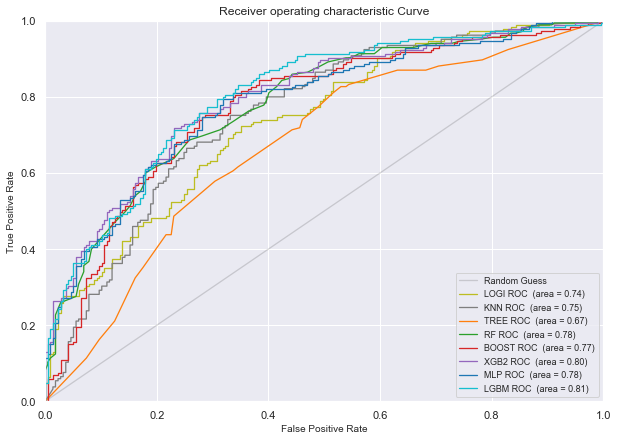

In [102]:
tableau20 = [ (188, 189, 34), (127, 127, 127),(255, 127, 14),(44, 160, 44),(214, 39, 40),  (148, 103, 189), 
             (31, 119, 180), (23, 190, 207), (158, 218, 229), (174, 199, 232), (247, 182, 210), 
             (127, 127, 127), (199, 199, 199), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
lw = 1.3
plt.plot([0, 1], [0, 1], lw=lw, color='black', alpha=0.15, label='Random Guess')

# Compute ROC curve and ROC area for each class
ll= [ [LOGI_test_all, LOGI_best_predictions_all],
     [KNN_test_all,KNN_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=['LOGI', 'KNN', 'TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  fpr = dict; tpr = dict; roc_auc = dict;
  fpr, tpr, _ = roc_curve(l[0][:], l[1][:]) # Calculating false positive rate and false negative rate
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=lw, label=names[i]+' ROC  (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Receiver operating characteristic Curve', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.show()

#### Plot of the Precision-Recall curve for all the classifiers for MCI to AD progression

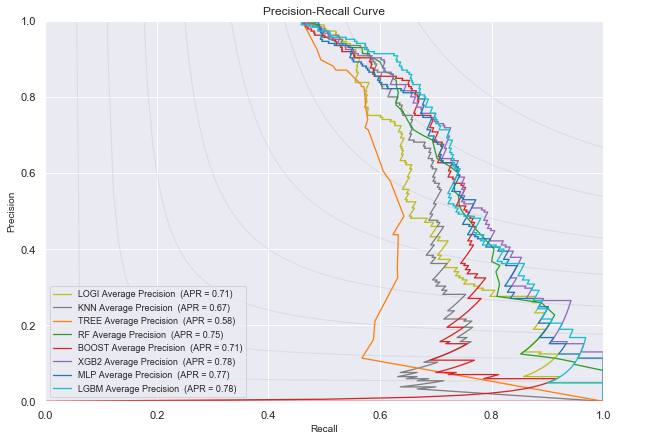

In [103]:
fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
f_scores = np.linspace(0.1, 0.8, num=8)
lines = []
labels = []
lw = 1.3

for f_score in f_scores:
    x = np.linspace(0.001, 1, num=100)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.15, lw=1)
    plt.annotate('f1 = {0:0.1f}'.format(f_score), xy=(1.05, y[80] + 0.01), fontsize=9)

# Compute ROC curve and ROC area for each class
ll= [ [LOGI_test_all, LOGI_best_predictions_all],
     [KNN_test_all,KNN_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all],]

names=['LOGI', 'KNN', 'TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  precision = dict; recall = dict; average_precision = dict;
  precision, recall, _ = precision_recall_curve(l[0][:], l[1][:]) 
  average_precision = average_precision_score(l[0][:], l[1][:])
  plt.plot(precision, recall, lw=lw, label=names[i]+r' Average Precision  (APR = %0.2f)' % average_precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision',fontsize=10)
plt.title('Precision-Recall Curve', fontsize=12)
plt.legend(loc="lower left", fontsize=9)
plt.show()

In [107]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
acc_mu=df.loc['Accuracy'][0::2].values
acc_std=df.loc['Accuracy'][1::2].values
dataframe = pd.DataFrame({'Accuracy_mean':acc_mu, 'Accuracy_std':acc_std}, index=names)
dataframe

,Accuracy_mean,Accuracy_std
KNN,0.701618,0.034070
LOGI,0.679363,0.037616
SVM,0.706422,0.022255
TREE,0.636765,0.029189
RF,0.713824,0.016442
BOOST,0.726275,0.027715
XGB,0.728873,0.024573
MLP,0.726422,0.032991
LGBM,0.743824,0.023258


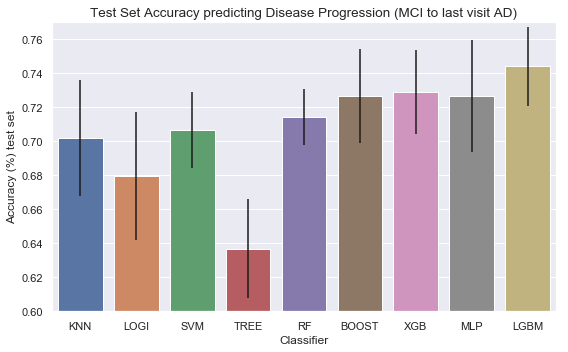

In [126]:
fig, ax= plt.subplots(1,1, figsize=(8,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax, yerr=dataframe['Accuracy_std'].values)
ax.set_ylim((0.60, 0.77))
ax.set_title('Test Set Accuracy predicting Disease Progression (MCI to last visit AD)', fontsize=13.5)
ax.set_ylabel('Accuracy (%) test set')
ax.set_xlabel('Classifier')
fig.tight_layout()

# 4 Results Summary

In [128]:
display('Normal->MCI/AD Progression model Results:')
df_normal_to_MCI_AD

'Normal->MCI/AD Progression model Results:'

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std,9 LGBM_mu,9 LGBM_std
Average Precision,0.307126,0.055251,0.442508,0.092327,0.320274,0.046882,0.277984,0.016486,0.359445,0.101354,0.447209,0.160570,0.355902,0.087726,0.386976,0.070872,0.386408,0.061556
AUROC,0.518669,0.026174,0.718563,0.094239,0.578921,0.024697,0.575596,0.019703,0.609578,0.070487,0.677120,0.101390,0.625656,0.086751,0.631931,0.049712,0.685346,0.030745
Precision,0.583333,0.433013,0.408554,0.120337,0.450000,0.321023,0.329487,0.078729,0.100000,0.173205,0.270833,0.308305,0.441288,0.327005,0.281250,0.184877,0.062500,0.108253
Recall,0.056319,0.032593,0.604396,0.145163,0.152473,0.095356,0.243132,0.090981,0.038462,0.066617,0.075549,0.094241,0.114011,0.039883,0.149725,0.119205,0.038462,0.066617
F1_Score,0.100298,0.058251,0.483180,0.122521,0.186090,0.068783,0.271626,0.077587,0.055556,0.096225,0.117647,0.144088,0.157790,0.036269,0.170481,0.114021,0.047619,0.082479
Sensitivity,0.056319,0.032593,0.604396,0.145163,0.152473,0.095356,0.243132,0.090981,0.038462,0.066617,0.075549,0.094241,0.114011,0.039883,0.149725,0.119205,0.038462,0.066617
Specificity,0.977273,0.022727,0.721591,0.090017,0.892045,0.090017,0.846591,0.049206,0.954545,0.035935,0.937500,0.070738,0.909091,0.073645,0.897727,0.107204,0.965909,0.059047
Accuracy,0.764141,0.020122,0.694192,0.088542,0.720584,0.050755,0.707426,0.031221,0.742362,0.025830,0.737976,0.065673,0.724894,0.050138,0.724894,0.057300,0.751059,0.028980


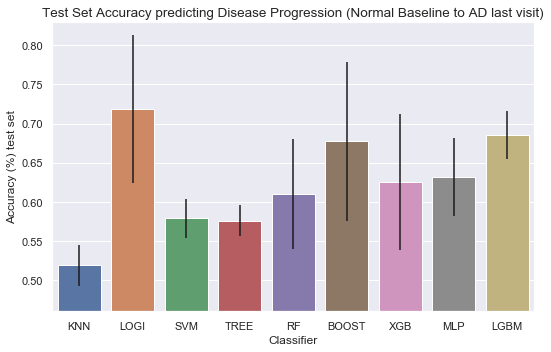

In [138]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
acc_mu=df_normal_to_MCI_AD.loc['AUROC'][0::2].values
acc_std=df_normal_to_MCI_AD.loc['AUROC'][1::2].values
dataframe = pd.DataFrame({'Accuracy_mean':acc_mu, 'Accuracy_std':acc_std}, index=names)
dataframe
fig, ax= plt.subplots(1,1, figsize=(8,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax, yerr=dataframe['Accuracy_std'].values)
ax.set_ylim((0.46, 0.83))
ax.set_title('Test Set Accuracy predicting Disease Progression (Normal Baseline to AD last visit)', fontsize=13.5)
ax.set_ylabel('Accuracy (%) test set')
ax.set_xlabel('Classifier')
fig.tight_layout()

**Conclusion:** For the model predicting normal Baseline to MCI or Alzheimer progression the Logistic regression, Gradiant Boosting and LGBM model have the highest AUROC and discrimitive power.

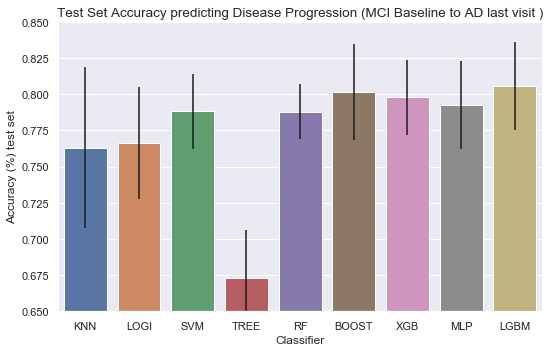

In [142]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
acc_mu=df.loc['AUROC'][0::2].values
acc_std=df.loc['AUROC'][1::2].values
dataframe = pd.DataFrame({'Accuracy_mean':acc_mu, 'Accuracy_std':acc_std}, index=names)
dataframe
fig, ax= plt.subplots(1,1, figsize=(8,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax, yerr=dataframe['Accuracy_std'].values)
ax.set_ylim((0.65, 0.85))
ax.set_title('Test Set Accuracy predicting Disease Progression (MCI Baseline to AD last visit )', fontsize=13.5)
ax.set_ylabel('Accuracy (%) test set')
ax.set_xlabel('Classifier')
fig.tight_layout()

In [131]:
display('MCI->AD Progression model Results::')
df.round(2)

'MCI->AD Progression model Results::'

,1 KNN_mu,1 KNN_std,2 LOGI_mu,2 LOGI_std,3 SVC_mu,3 SVC_std,4 TREE_mu,4 TREE_std,5 RF_mu,5 RF_std,6 BOOST_mu,6 BOOST_std,7 XGB2_mu,7 XGB2_std,8 MLP_mu,8 MLP_std,9 LGBM_mu,9 LGBM_std
Average Precision,0.69,0.05,0.74,0.05,0.76,0.04,0.59,0.04,0.76,0.02,0.78,0.05,0.79,0.02,0.77,0.04,0.79,0.03
AUROC,0.76,0.06,0.77,0.04,0.79,0.03,0.67,0.03,0.79,0.02,0.80,0.03,0.80,0.03,0.79,0.03,0.81,0.03
Precision,0.67,0.07,0.65,0.06,0.68,0.04,0.61,0.03,0.70,0.04,0.71,0.05,0.72,0.04,0.72,0.05,0.73,0.04
Recall,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
F1_Score,0.70,0.02,0.67,0.03,0.69,0.02,0.59,0.09,0.68,0.03,0.70,0.02,0.70,0.02,0.69,0.05,0.72,0.02
Sensitivity,0.74,0.07,0.71,0.09,0.70,0.06,0.61,0.16,0.67,0.08,0.70,0.04,0.68,0.01,0.68,0.08,0.71,0.01
Specificity,0.67,0.11,0.65,0.12,0.71,0.08,0.66,0.10,0.75,0.07,0.75,0.07,0.77,0.05,0.77,0.05,0.77,0.04
Accuracy,0.70,0.03,0.68,0.04,0.71,0.02,0.64,0.03,0.71,0.02,0.73,0.03,0.73,0.02,0.73,0.03,0.74,0.02


**Conclusion:** For the model predicting MCI Baseline to  Alzheimer progression the Gradiant Boosting, XGBoost and LGBM model that have the highest AUROC and discrimitive power!